<div align='center'>

# Unsupervised Learning - Part 2

### Part of Scientific-ML-Notes 

[![GitHub](https://img.shields.io/badge/GitHub-Repository-black?logo=github&scale=5)](https://github.com/mhnaderi/Scientific-ML-Notes)

---

In [1]:
#! Always run this cell first to import all necessary libraries and to set up the notebook environment
import numpy as np
import scipy as sp
from sklearn.datasets import make_circles
from sklearn.datasets import load_sample_image

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.rcParams.update({"font.family": "serif"})
plt.rcParams.update({"figure.facecolor": 'white', "axes.facecolor": 'white'})

# Dimensionality Reduction

**Manifold Learning:** Manifold learning techniques operate on the assumption that high-dimensional data resides on a lower-dimensional manifold embedded within the higher-dimensional space. These methods aim to uncover this manifold structure and project the data onto it. Unlike autoencoders, manifold learning typically **does not involve a decoder** component. Examples of manifold learning algorithms include t-SNE, Isomap, and Locally Linear Embedding (LLE).

**Autoencoders:** Autoencoders are unsupervised neural networks designed to learn compressed representations of input data. They consist of two main parts: an encoder and a decoder. The encoder maps high-dimensional input data to a lower-dimensional latent space representation, while the decoder reconstructs the original input data from this lower-dimensional representation.

## Singular Value Decomposition (SVD)

In this section, we'll explore how Singular Value Decomposition (SVD) can be utilized for dimensionality reduction, along with some of its variations.

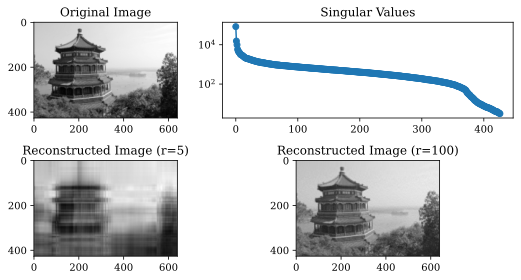

In [2]:
# Step 1: Load the China image from the sklearn library
image = load_sample_image('china.jpg')

# Convert the image to grayscale
image = np.dot(image[...,:3], [0.2989, 0.5870, 0.1140])

# Step 2: Perform SVD on the image
U, S, Vt = np.linalg.svd(image, full_matrices=False)

# Step 3: Plot the original image, reconstructed images and singular values
fig, axs = plt.subplots(2, 2, figsize=(8, 4), tight_layout=True)

# Plot the original image
axs[0,0].imshow(image, cmap='gray')
axs[0,0].set_title('Original Image')

# Plot the singular values
axs[0,1].semilogy(S, 'o-')
axs[0,1].set_title('Singular Values')

# Reconstruct and plot the image with different numbers of singular values
for i, r in enumerate([5, 100]):
    # Use the first r singular values/vectors
    image_reconstructed = U[:,:r] * S[:r] @ Vt[:r,:]
    
    # Plot the reconstructed image
    axs[1,i].imshow(image_reconstructed, cmap='gray')
    axs[1,i].set_title(f'Reconstructed Image (r={r})')

### Randomized SVD

Randomized SVD is an efficient approximation of the standard SVD algorithm, particularly useful for large matrices where traditional SVD computations are computationally intensive. It leverages random projections to estimate the singular vectors and singular values of a matrix. While we still require access to all elements of the matrix, the computation is significantly faster compared to the conventional SVD approach.

Text(0.5, 1.0, 'Reconstructed Image with Randomized SVD - r=100')

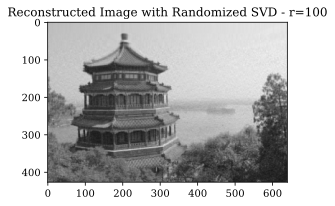

In [3]:
def rSVD(X, r, q, p): 
    # Step 1: Sample column space of X with P matrix 
    ny = X.shape[1] 
    P = np.random.randn(ny, r+p) 
    Z = X @ P  
    for k in range(q): 
        Z = X @ (X.T @ Z)  
    Q, R = np.linalg.qr(Z)  
                        
    # Step 2: Compute SVD on projected Y = Q.T @ X 
    Y = Q.T @ X 
    UY, S, VT = np.linalg.svd(Y ,full_matrices=False) 
    U = Q @ UY  

    return U, S, VT

image = load_sample_image('china.jpg')
image = np.dot(image[...,:3], [0.2989, 0.5870, 0.1140])

r = 100
U, S, Vt = rSVD(image, r, 1, 1)

image_reconstructed = U * S @ Vt

fig, ax = plt.subplots(1, 1, figsize=(4, 4), tight_layout=True)
ax.imshow(image_reconstructed, cmap='gray')
ax.set_title(f'Reconstructed Image with Randomized SVD - r={r}')

### Kernel Principal Component Analysis (kPCA)

Kernel Principal Component Analysis (kPCA) is a nonlinear extension of standard PCA that enables the discovery of complex structures within the data. It achieves this by first applying a nonlinear transformation to the data and then performing PCA in the resulting feature space.

#### Nonlinear Transformation and Feature Space

kPCA employs a nonlinear mapping function $ \xi: \mathbb{R}^{n_s} \rightarrow \mathbb{R}^{n_f} $ to transform the original data into a higher-dimensional feature space. This transformation emphasizes certain features in the data, making it easier to uncover patterns and structures that might be hidden in the original space. Linear operations in this feature space, such as projections, correspond to nonlinear operations in the original data space.

#### The Kernel Trick and Kernel Functions

To perform kPCA efficiently without explicitly computing coordinates in the high-dimensional feature space, we utilize the kernel trick. This involves using a kernel function, $ \kappa(\boldsymbol{d}_i, \boldsymbol{d}_j): \mathbb{R}^{n_s} \times \mathbb{R}^{n_s} \rightarrow \mathbb{R} $, which computes the inner products between data points in the feature space:

$$
\kappa(\boldsymbol{d}_i, \boldsymbol{d}_j) = \langle \xi(\boldsymbol{d}_i), \xi(\boldsymbol{d}_j) \rangle = \xi^T(\boldsymbol{d}_i) \, \xi(\boldsymbol{d}_j)
$$

By using the kernel function, we avoid the need to explicitly define or compute the nonlinear transformation $ \xi $. This approach allows us to perform kPCA more efficiently, as calculations are based solely on the kernel function applied to pairs of data points in the original space.

Text(0.5, 1.0, 'Kernel PCA with Gaussian Kernel')

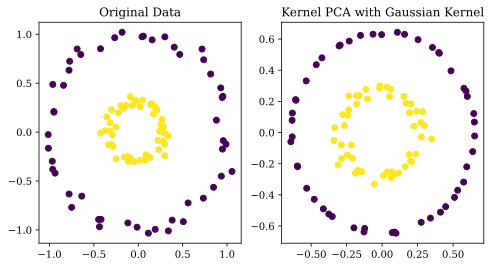

In [4]:
# Define a kernel function (e.g., Gaussian/RBF kernel)
def gaussian_kernel(x, y, sigma=1):
    return np.exp(-np.linalg.norm(x - y)**2 / (2 * (sigma ** 2)))

# Compute the kernel matrix
def compute_kernel_matrix(X, kernel_function):
    n_samples = X.shape[0]
    K = np.zeros((n_samples, n_samples))

    for i in range(n_samples):
        for j in range(n_samples):
            K[i, j] = kernel_function(X[i], X[j])

    return K

# Center the kernel matrix
def center_kernel_matrix(K):
    n_samples = K.shape[0]
    one_n = np.ones((n_samples, n_samples)) / n_samples
    K_centered = K - one_n@K - K@one_n + one_n@K@one_n
    return K_centered

# Kernel PCA function
def kernel_pca(X, kernel_function, n_components):
    # Compute the kernel matrix
    K = compute_kernel_matrix(X, kernel_function)

    # Center the kernel matrix
    K_centered = center_kernel_matrix(K)

    # Perform SVD on the centered kernel matrix
    U, S, V = np.linalg.svd(K_centered)

    # Select the top n_components eigenvectors
    U_reduced = U[:,:n_components]

    # Project the data onto the reduced eigenvectors
    X_kpca = U_reduced * np.sqrt(S[:n_components])

    return X_kpca

# Generate synthetic dataset
X, y = make_circles(n_samples=100, factor=0.3, noise=0.05)

# Apply kernel PCA using Gaussian kernel
X_kpca = kernel_pca(X, gaussian_kernel, n_components=2)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
plt.title("Original Data")
plt.subplot(1, 2, 2)
plt.scatter(X_kpca[:, 0], X_kpca[:, 1], c=y, cmap='viridis')
plt.title("Kernel PCA with Gaussian Kernel")

### Robust PCA

In the "ML 1" notebook, we observed that least-squares methods, such as standard PCA, are highly sensitive to outliers and corrupted data. **Robust PCA (RPCA)** addresses this issue by decomposing the data matrix $\mathbf{X}$ into two components: a low-rank matrix $\mathbf{L}$ representing the underlying structure, and a sparse matrix $\mathbf{S}$ capturing outliers and corruptions:

$$
\mathbf{X} = \mathbf{L} + \mathbf{S}
$$

The aim is to recover the principal components from $\mathbf{L}$, which are robust to the outliers contained in $\mathbf{S}$. Mathematically, RPCA solves the following optimization problem:

$$
\min_{\mathbf{L},\,\mathbf{S}}\, \|\mathbf{L}\|_* + \lambda \|\mathbf{S}\|_1 \quad \text{subject to} \quad \mathbf{X} = \mathbf{L} + \mathbf{S}
$$

Here, $\|\cdot\|_*$ denotes the nuclear norm (sum of singular values) promoting low-rankness in $\mathbf{L}$, and $\|\cdot\|_1$ is the $\ell_1$ norm encouraging sparsity in $\mathbf{S}$. Under certain conditions, the solution to this problem converges when $\lambda = 1 / \sqrt{\max(n, m)}$, where $n$ and $m$ are the dimensions of $\mathbf{X}$. The key assumptions are:

1. **The low-rank matrix $\mathbf{L}$ is not sparse**; its singular vectors are incoherent with the standard basis.
2. **The sparse matrix $\mathbf{S}$ has randomly distributed non-zero entries**; it does not exhibit low-rank structure.

## Factor Analysis (FA)

**Factor Analysis** is a statistical model that explains observed variables through a smaller number of unobserved latent factors. The model assumes that both the prior over latent factors and the likelihood are Gaussian, with the likelihood using a linear transformation for the mean. Given a data matrix $\mathbf{X} \in \mathbb{R}^{N \times D}$, the generative model is defined as:

$$
\begin{aligned}
p(\boldsymbol{z}) &= \mathcal{N}(\boldsymbol{z} \mid \mathbf{0}, \mathbf{I}) \\
p(\boldsymbol{x} \mid \boldsymbol{z}) &= \mathcal{N}(\boldsymbol{x} \mid \mathbf{W} \boldsymbol{z} + \boldsymbol{\mu},\, \boldsymbol{\Psi})
\end{aligned}
$$

Here, $\mathbf{W} \in \mathbb{R}^{D \times r}$ is the **factor loading matrix**, $\boldsymbol{\mu} \in \mathbb{R}^{D}$ is the mean, and $\boldsymbol{\Psi} \in \mathbb{R}^{D \times D}$ is a diagonal covariance matrix representing noise.

### Computing the Posterior

Using results from Bayesian linear regression and applying the matrix inversion lemma, we can derive the posterior distribution over the latent variables given the observations:

$$
\begin{aligned}
p(\boldsymbol{z} \mid \boldsymbol{x}) &= \mathcal{N}(\boldsymbol{z} \mid \boldsymbol{\mu}_{z \mid x},\, \boldsymbol{\Sigma}_{z \mid x}) \\
\boldsymbol{\Sigma}_{z \mid x} &= \left( \mathbf{I} + \mathbf{W}^\top \boldsymbol{\Psi}^{-1} \mathbf{W} \right)^{-1} = \mathbf{I} - \mathbf{W}^\top \left( \mathbf{W} \mathbf{W}^\top + \boldsymbol{\Psi} \right)^{-1} \mathbf{W} \\
\boldsymbol{\mu}_{z \mid x} &= \boldsymbol{\Sigma}_{z \mid x} \mathbf{W}^\top \boldsymbol{\Psi}^{-1} (\boldsymbol{x} - \boldsymbol{\mu}) = \mathbf{W}^\top \left( \mathbf{W} \mathbf{W}^\top + \boldsymbol{\Psi} \right)^{-1} (\boldsymbol{x} - \boldsymbol{\mu})
\end{aligned}
$$

To avoid direct inversion of the $D \times D$ matrix $\mathbf{C} = \mathbf{W} \mathbf{W}^\top + \boldsymbol{\Psi}$, we apply the **Woodbury matrix identity**:

$$
\mathbf{C}^{-1} = \boldsymbol{\Psi}^{-1} - \boldsymbol{\Psi}^{-1} \mathbf{W} \left( \mathbf{I} + \mathbf{W}^\top \boldsymbol{\Psi}^{-1} \mathbf{W} \right)^{-1} \mathbf{W}^\top \boldsymbol{\Psi}^{-1}
$$

This approach reduces computational complexity, as we invert an $r \times r$ matrix instead of a $D \times D$ one.

### Computing the Likelihood

The log-likelihood of the data can be efficiently computed as:

$$
\log p(\boldsymbol{x} \mid \boldsymbol{\mu},\, \mathbf{C}) = -\frac{1}{2} \left[ D \log(2\pi) + \log \det(\mathbf{C}) + (\boldsymbol{x} - \boldsymbol{\mu})^\top \mathbf{C}^{-1} (\boldsymbol{x} - \boldsymbol{\mu}) \right]
$$

Using the Woodbury identity and the **matrix determinant lemma**, we compute $\mathbf{C}^{-1}$ and $\log \det(\mathbf{C})$ without explicit inversion, thus improving computational efficiency.

### Model Fitting with Expectation Maximization (EM)

The EM algorithm iteratively estimates the model parameters:

**E-Step**: Compute expected sufficient statistics:

$$
\begin{aligned}
\mathbb{E}_{\boldsymbol{x},\, \boldsymbol{z}} &= \sum_{n=1}^N \boldsymbol{x}_n \mathbb{E}[\boldsymbol{z}_n \mid \boldsymbol{x}_n]^\top \\
\mathbb{E}_{\boldsymbol{z},\, \boldsymbol{z}} &= \sum_{n=1}^N \mathbb{E}[\boldsymbol{z}_n \boldsymbol{z}_n^\top \mid \boldsymbol{x}_n] \\
\mathbb{E}_{\boldsymbol{x},\, \boldsymbol{x}} &= \sum_{n=1}^N \boldsymbol{x}_n \boldsymbol{x}_n^\top
\end{aligned}
$$

with

$$
\begin{aligned}
\mathbb{E}[\boldsymbol{z}_n \mid \boldsymbol{x}_n] &= \mathbf{B} (\boldsymbol{x}_n - \boldsymbol{\mu}) \\
\mathbb{E}[\boldsymbol{z}_n \boldsymbol{z}_n^\top \mid \boldsymbol{x}_n] &= \boldsymbol{\Sigma}_{z \mid x} + \mathbb{E}[\boldsymbol{z}_n \mid \boldsymbol{x}_n] \mathbb{E}[\boldsymbol{z}_n \mid \boldsymbol{x}_n]^\top \\
\mathbf{B} &= \boldsymbol{\Sigma}_{z \mid x} \mathbf{W}^\top \boldsymbol{\Psi}^{-1} \\
\boldsymbol{\Sigma}_{z \mid x} &= \left( \mathbf{I} + \mathbf{W}^\top \boldsymbol{\Psi}^{-1} \mathbf{W} \right)^{-1}
\end{aligned}
$$

**M-Step**: Update parameters:

$$
\begin{aligned}
\mathbf{W}^{\text{new}} &= \mathbb{E}_{\boldsymbol{x},\, \boldsymbol{z}} \left( \mathbb{E}_{\boldsymbol{z},\, \boldsymbol{z}} \right)^{-1} \\
\boldsymbol{\Psi}^{\text{new}} &= \frac{1}{N} \operatorname{diag} \left( \mathbb{E}_{\boldsymbol{x},\, \boldsymbol{x}} - \mathbf{W}^{\text{new}} \mathbb{E}_{\boldsymbol{x},\, \boldsymbol{z}}^\top \right)
\end{aligned}
$$

We assume the data is centered (i.e., $\boldsymbol{\mu} = \mathbf{0}$) for simplicity.

### Handling Missing Data

Factor analysis can handle missing data under the assumption of missing at random. By partitioning $\boldsymbol{x}$ into observed $\boldsymbol{x}_o$ and missing $\boldsymbol{x}_m$ components, we adjust the posterior computations:

$$
\begin{aligned}
p(\boldsymbol{z} \mid \boldsymbol{x}_o) &= \mathcal{N}(\boldsymbol{z} \mid \boldsymbol{\mu}_{z \mid o},\, \boldsymbol{\Sigma}_{z \mid o}) \\
\boldsymbol{\Sigma}_{z \mid o}^{-1} &= \mathbf{I} + \mathbf{W}_o^\top \boldsymbol{\Psi}_{oo}^{-1} \mathbf{W}_o \\
\boldsymbol{\mu}_{z \mid o} &= \boldsymbol{\Sigma}_{z \mid o} \mathbf{W}_o^\top \boldsymbol{\Psi}_{oo}^{-1} (\boldsymbol{x}_o - \boldsymbol{\mu}_o)
\end{aligned}
$$

where $\mathbf{W}_o$ and $\boldsymbol{\Psi}_{oo}$ correspond to observed variables.

### Identifiability of Parameters

**Unidentifiability** arises because the factor analysis model is invariant under certain transformations:

- **Rotational Invariance**: For any orthogonal matrix $\mathbf{R}$, transforming $\mathbf{W} \to \mathbf{W} \mathbf{R}$ and $\boldsymbol{z} \to \mathbf{R}^\top \boldsymbol{z}$ leaves the model unchanged.
- **Scaling and Permutation**: Similar invariances exist for scaling and rearranging factors.

To address this:

- **Constraining $\mathbf{W}$**: Enforce specific structures, like orthogonality or lower-triangular form.
- **Sparse Factor Loading**: Use regularization (e.g., $\ell_1$ norm) to encourage sparsity in $\mathbf{W}$.
- **Factor Rotation**: Apply techniques like varimax rotation to enhance interpretability.
- **Non-Gaussian Latent Variables**: Employ non-Gaussian priors for $\boldsymbol{z}$ to potentially achieve identifiability.

### Probabilistic PCA (PPCA)

**Probabilistic PCA** is a special case of factor analysis with an isotropic noise covariance matrix $\boldsymbol{\Psi} = \sigma^2 \mathbf{I}$. The model simplifies to:

$$
p(\boldsymbol{x} \mid \boldsymbol{z}) = \mathcal{N}(\boldsymbol{x} \mid \mathbf{W} \boldsymbol{z} + \boldsymbol{\mu},\, \sigma^2 \mathbf{I})
$$

This probabilistic framework allows for maximum likelihood estimation of parameters in closed form.

#### Derivation of the MLE

The maximum likelihood estimates are derived via eigen-decomposition of the sample covariance matrix $\mathbf{S}$. The MLE for $\mathbf{W}$ is:

$$
\hat{\mathbf{W}} = \mathbf{U}_r (\boldsymbol{\Lambda}_r - \sigma^2 \mathbf{I})^{1/2} \mathbf{R}
$$

where:

- $\mathbf{U}_r$ contains the top $r$ eigenvectors of $\mathbf{S}$.
- $\boldsymbol{\Lambda}_r$ is a diagonal matrix of the top $r$ eigenvalues.
- $\mathbf{R}$ is an arbitrary orthogonal matrix.

The noise variance is estimated as:

$$
\sigma^2 = \frac{1}{D - r} \sum_{i = r+1}^D \lambda_i
$$

At the limit $\sigma^2 \to 0$, PPCA converges to standard PCA.

#### Computing the Posterior

The posterior over latent variables is:

$$
p(\boldsymbol{z} \mid \boldsymbol{x}) = \mathcal{N}\left( \boldsymbol{z} \mid \boldsymbol{M}^{-1} \mathbf{W}^\top (\boldsymbol{x} - \boldsymbol{\mu}),\, \sigma^2 \boldsymbol{M}^{-1} \right)
$$

with $\boldsymbol{M} = \mathbf{W}^\top \mathbf{W} + \sigma^2 \mathbf{I}$. In the limit $\sigma^2 \to 0$, the posterior mean simplifies to:

$$
\mathbb{E}[\boldsymbol{z} \mid \boldsymbol{x}] = (\mathbf{W}^\top \mathbf{W})^{-1} \mathbf{W}^\top (\boldsymbol{x} - \boldsymbol{\mu})
$$

which corresponds to the principal components obtained in standard PCA.

#### EM Algorithm for PPCA

An alternative to direct eigen-decomposition is to use the EM algorithm:

**E-Step**:

Compute expected latent variables:

$$
\tilde{\mathbf{Z}} = (\mathbf{W}^\top \mathbf{W})^{-1} \mathbf{W}^\top \tilde{\mathbf{X}}
$$

where $\tilde{\mathbf{X}} = \mathbf{X} - \hat{\boldsymbol{\mu}}$.

**M-Step**:

Update parameters:

$$
\mathbf{W}^{\text{new}} = \tilde{\mathbf{X}} \tilde{\mathbf{Z}}^\top (\tilde{\mathbf{Z}} \tilde{\mathbf{Z}}^\top)^{-1}
$$

In the noise-free limit ($\sigma^2 \to 0$), the covariance simplifies, and the algorithm becomes an efficient alternative for computing PCA components.

# Clustering

## Gaussian Mixture Models (GMMs)

To model complex data distributions, we can combine simpler probability models using a convex combination. This approach is known as a **mixture model**, defined as:

$$
p(\boldsymbol{x} \mid \boldsymbol{\theta}) = \sum_{k=1}^K \pi_k\, p_k(\boldsymbol{x})
$$

Here, each $ p_k(\boldsymbol{x}) $ is the $ k $-th component distribution, and $ \pi_k $ are the mixture weights satisfying $ 0 \leq \pi_k \leq 1 $ and $ \sum_{k=1}^K \pi_k = 1 $.

A **Gaussian Mixture Model (GMM)** is a specific type of mixture model where each component is a Gaussian distribution:

$$
p(\boldsymbol{x}) = \sum_{k=1}^K \pi_k\, \mathcal{N}(\boldsymbol{x} \mid \boldsymbol{\mu}_k,\, \boldsymbol{\Sigma}_k)
$$

GMMs are widely used for unsupervised clustering of real-valued data points $ \boldsymbol{x}_n \in \mathbb{R}^D $. The clustering process involves two main steps:

1. **Model Fitting**: Estimate the parameters $ \boldsymbol{\theta} = \{ \pi_k,\, \boldsymbol{\mu}_k,\, \boldsymbol{\Sigma}_k \} $ using methods like Maximum Likelihood Estimation (MLE) or Expectation-Maximization (EM).

2. **Cluster Assignment**: Assign each data point $ \boldsymbol{x}_n $ to a cluster based on a latent variable $ z_n \in \{1, 2, \dotsc, K\} $, which indicates the component responsible for generating $ \boldsymbol{x}_n $. Since $ z_n $ is unobserved, we compute the posterior probability using Bayes' theorem:

   $$
   r_{nk} \equiv p(z_n = k \mid \boldsymbol{x}_n,\, \boldsymbol{\theta}) = \frac{\pi_k\, p_k(\boldsymbol{x}_n)}{\sum_{j=1}^K \pi_j\, p_j(\boldsymbol{x}_n)}
   $$

   The quantity $ r_{nk} $ is called the **responsibility** that component $ k $ takes for data point $ n $.

For **hard clustering**, we assign each data point to the cluster with the highest responsibility:

$$
\hat{z}_n = \arg\max_k\, r_{nk} = \arg\max_k\, \left[ \log p_k(\boldsymbol{x}_n) + \log \pi_k \right]
$$

If we assume uniform mixture weights (i.e., all $ \pi_k $ are equal) and use spherical covariance matrices (i.e., $ \boldsymbol{\Sigma}_k = \mathbf{I} $), the cluster assignment simplifies to:

$$
\hat{z}_n = \arg\min_k\, \| \boldsymbol{x}_n - \boldsymbol{\mu}_k \|_2^2
$$

In this case, each data point is assigned to the nearest cluster centroid based on Euclidean distance. **This is the foundation of the K-means clustering algorithm**.

In contrast, **soft clustering** considers the responsibilities $ r_{nk} $ to assign data points to clusters probabilistically, allowing for fractional membership.

### Unidentifiability of Mixture Models

An important consideration with mixture models is the **unidentifiability** of their parameters due to the **label-switching problem**. This means that permuting the labels of the clusters results in an equivalent model.

For example, suppose we fit a GMM with two components to data generated from a true GMM with parameters $ \boldsymbol{\theta}^\ast = \{ \pi_k^\ast,\, \boldsymbol{\mu}_k^\ast,\, \boldsymbol{\Sigma}_k^\ast \} $. The maximum likelihood estimate $ \hat{\boldsymbol{\theta}} $ minimizes the Kullback-Leibler divergence between the true distribution and our model:

$$
\hat{\boldsymbol{\theta}} = \arg\min_{\boldsymbol{\theta}}\, D_{\mathrm{KL}}\left( p^\ast(\boldsymbol{x}) \,\|\, p(\boldsymbol{x} \mid \boldsymbol{\theta}) \right)
$$

However, there are multiple sets of parameters that yield the same likelihood due to the interchangeability of component labels. Specifically:

- $ \hat{\boldsymbol{\mu}}_1 = \boldsymbol{\mu}_1^\ast $ and $ \hat{\boldsymbol{\mu}}_2 = \boldsymbol{\mu}_2^\ast $
- $ \hat{\boldsymbol{\mu}}_1 = \boldsymbol{\mu}_2^\ast $ and $ \hat{\boldsymbol{\mu}}_2 = \boldsymbol{\mu}_1^\ast $

Both parameter sets are equally valid, as the labels of the clusters are arbitrary. This ambiguity means that computing the posterior mean of cluster parameters may not provide meaningful insights, particularly in a Bayesian context where parameter estimates are averaged over their posterior distributions.

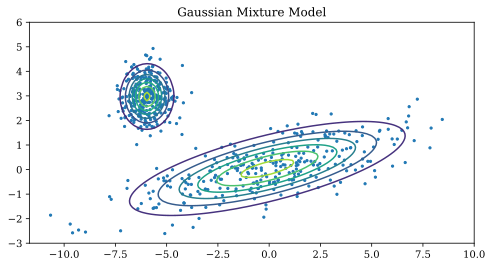

In [5]:
# Generate synthetic data
np.random.seed(0)
n_samples = 300

# Generate random Gaussian data
C = np.array([[0., -0.7], [3.5, .7]])
X = np.r_[np.dot(np.random.randn(n_samples, 2), C), .7 * np.random.randn(n_samples, 2) + np.array([-6, 3])]

# Initialize parameters
n_components = 2
weights = np.ones((n_components,)) / n_components
means = np.random.choice(X.flatten(), (n_components,X.shape[1]))
covariances = np.array([np.eye(X.shape[1])]*n_components)

for _ in range(50): # Number of EM iterations
    # E-step
    likelihood = np.array([w*sp.stats.multivariate_normal(m, c).pdf(X) for m, c, w in zip(means, covariances, weights)])
    responsibilities = likelihood / likelihood.sum(axis=0)

    # M-step
    weights = responsibilities.sum(axis=1)
    weights /= n_samples

    for i in range(n_components):
        means[i] = (responsibilities[i, :, None] * X).sum(axis=0) / responsibilities[i].sum()
        diff = (X - means[i]).T
        covariances[i] = np.dot(responsibilities[i] * diff, diff.T) / responsibilities[i].sum()

    weights /= weights.sum()

# Plot the data and the Gaussian distributions
plt.figure(figsize=(8, 4))
plt.scatter(X[:, 0], X[:, 1], s=5)

x = np.linspace(-10., 10., 100)
y = np.linspace(-3., 6., 100)
X_, Y_ = np.meshgrid(x, y)
XX = np.array([X_.ravel(), Y_.ravel()]).T

for m, c in zip(means, covariances):
    Z = sp.stats.multivariate_normal(m, c).pdf(XX)
    Z = Z.reshape(X_.shape)
    plt.contour(X_, Y_, Z)

plt.title("Gaussian Mixture Model")
plt.show()